# Chapter 03: Multi-Series Fitting

This notebook demonstrates one of vangja's key features: **vectorized multi-series fitting**. Unlike Facebook Prophet, which fits time series one at a time, vangja can fit multiple time series **simultaneously** using vectorized computations.

We'll compare two approaches:
1. **Sequential fitting (Prophet-style)**: Fit each time series independently, one after another
2. **Simultaneous fitting (Vangja-style)**: Fit all time series at once with `pool_type="individual"`

Both approaches produce equivalent results when series share the same time range, but the vectorized approach is significantly faster when you have many time series.

**Note**: For series with different date ranges, see Chapter 04 which covers important caveats.

## Setup and Imports

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.datasets import generate_multi_store_data
from vangja.utils import metrics

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## Generate Synthetic Multi-Store Data

We'll use **5 synthetic time series** representing different stores, all sharing the **same time range** (2015-2020). This is the ideal scenario for simultaneous fitting.

Each series has:
- A linear trend with different slopes
- Yearly seasonality with different amplitudes
- Weekly seasonality
- Random noise

Vangja provides `generate_multi_store_data()` in `vangja.datasets` for this purpose.

In [4]:
# Generate synthetic multi-store data
all_data, series_params = generate_multi_store_data(seed=42)

# Split into individual series for later use
all_series = [all_data[all_data["series"] == name].reset_index(drop=True) 
              for name in all_data["series"].unique()]

print(f"Date range: {all_data['ds'].min().date()} to {all_data['ds'].max().date()}")
print(f"Total days per series: {len(all_series[0])}")
print(f"Number of series: {len(all_series)}")

Date range: 2015-01-01 to 2019-12-31
Total days per series: 1826
Number of series: 5


In [5]:
# Display series information
for params in series_params:
    series_df = all_data[all_data["series"] == params["name"]]
    print(
        f"{params['name']}: {len(series_df)} samples, y range: {series_df['y'].min():.1f} to {series_df['y'].max():.1f}"
    )

print(f"\nTotal combined data: {len(all_data)} samples")

store_north: 1826 samples, y range: 61.2 to 232.2
store_south: 1826 samples, y range: 45.0 to 185.2
store_east: 1826 samples, y range: 75.1 to 292.2
store_west: 1826 samples, y range: 66.5 to 166.1
store_central: 1826 samples, y range: 81.0 to 354.4

Total combined data: 9130 samples


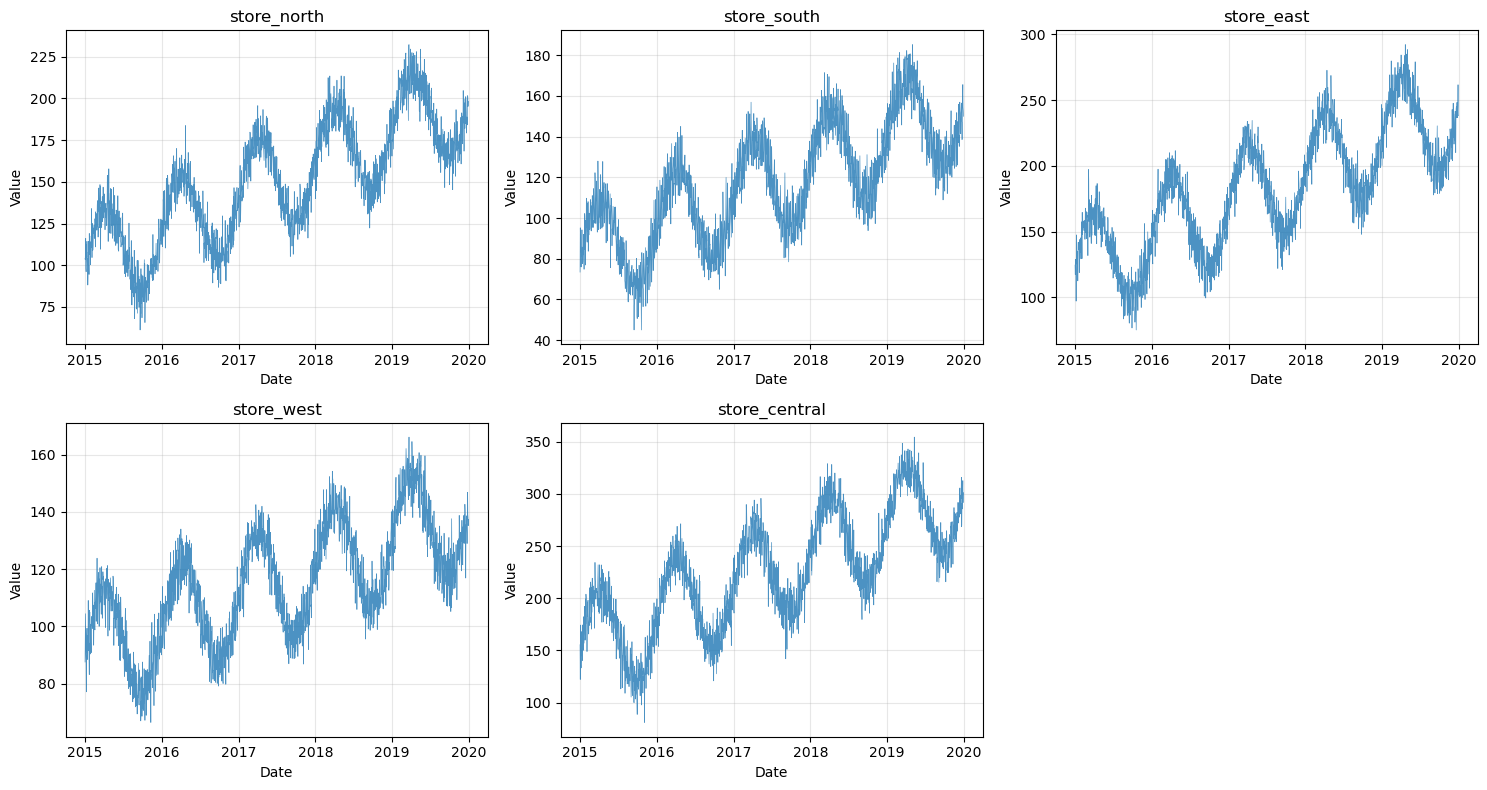

In [6]:
# Visualize all series
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, params in enumerate(series_params):
    ax = axes[i]
    series_df = all_data[all_data["series"] == params["name"]]
    ax.plot(series_df["ds"], series_df["y"], linewidth=0.5, alpha=0.8)
    ax.set_title(params["name"])
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)

# Hide the 6th subplot
axes[5].axis("off")

plt.tight_layout()
plt.show()

## Prepare Train/Test Splits

We'll hold out the last 365 days (1 year) of each series for testing.

In [7]:
test_days = 365

train_series = []
test_series = []

for series_df in all_series:
    train_series.append(series_df[:-test_days].copy())
    test_series.append(series_df[-test_days:].copy())

# Combined training data
train_combined = pd.concat(train_series, ignore_index=True)

print(f"Training data per series: {len(train_series[0])} samples")
print(f"Test data per series: {len(test_series[0])} samples")
print(f"Total training samples: {len(train_combined)}")

Training data per series: 1461 samples
Test data per series: 365 samples
Total training samples: 7305


---

## Approach 1: Sequential Fitting (Prophet-style)

In the traditional approach (like Facebook Prophet), we fit each time series separately. This means:
- Creating a new model instance for each series
- Fitting each model independently
- Total time = sum of individual fitting times

This approach works fine for a few time series, but becomes slow when you have many series.

In [8]:
def create_model():
    """Create an additive model with trend and seasonality."""
    return (
        LinearTrend(n_changepoints=15)
        + FourierSeasonality(period=365.25, series_order=10)
        + FourierSeasonality(period=7, series_order=3)
    )


print(f"Model structure: {create_model()}")

Model structure: LT(n=15,r=0.8,tm=None) + FS(p=365.25,n=10,tm=None) + FS(p=7,n=3,tm=None)


In [9]:
# Fit each series sequentially
sequential_models = []
sequential_times = []

print("Sequential fitting:")
total_start = time.time()

for i, (train_df, params) in enumerate(zip(train_series, series_params)):
    model = create_model()
    start = time.time()
    model.fit(train_df, method="mapx")
    elapsed = time.time() - start
    sequential_times.append(elapsed)
    sequential_models.append(model)
    print(f"  {params['name']}: {elapsed:.2f}s")

total_sequential_time = time.time() - total_start
print(f"\nTotal sequential time: {total_sequential_time:.2f}s")

Sequential fitting:


Output()

  store_north: 3.41s


Output()

  store_south: 1.58s


Output()

  store_east: 1.68s


Output()

  store_west: 2.26s


Output()

  store_central: 1.65s

Total sequential time: 10.58s


In [10]:
# Generate predictions and calculate metrics for sequential fitting
sequential_futures = []
sequential_metrics = []

for model, test_df, params in zip(sequential_models, test_series, series_params):
    future = model.predict(horizon=test_days, freq="D")
    sequential_futures.append(future)
    m = metrics(test_df, future, "complete")
    m.index = [params["name"]]
    sequential_metrics.append(m)

sequential_metrics_df = pd.concat(sequential_metrics)
print("Sequential Fitting Metrics:")
display(sequential_metrics_df)

Sequential Fitting Metrics:


,mse,rmse,mae,mape
store_north,65.589342,8.098725,6.450520,0.034214
store_south,40.167320,6.337769,5.071716,0.034952
store_east,92.251552,9.604767,7.644443,0.033662
store_west,28.766430,5.363435,4.284655,0.031891
store_central,131.073982,11.448755,9.184140,0.032899


---

## Approach 2: Simultaneous Fitting (Vangja-style)

Vangja can fit multiple time series **simultaneously** by:
1. Combining all series into a single DataFrame with a `series` column
2. Using `pool_type="individual"` so each series gets its own parameters
3. Using `scale_mode="individual"` so each series is scaled independently

This approach leverages vectorized computations in PyMC/JAX, which is significantly faster than fitting models sequentially.

In [11]:
def create_model_individual():
    """Create an additive model with individual pooling for multi-series fitting."""
    return (
        LinearTrend(n_changepoints=15, pool_type="individual")
        + FourierSeasonality(period=365.25, series_order=10, pool_type="individual")
        + FourierSeasonality(period=7, series_order=3, pool_type="individual")
    )


print(f"Model structure: {create_model_individual()}")

Model structure: LT(n=15,r=0.8,tm=None) + FS(p=365.25,n=10,tm=None) + FS(p=7,n=3,tm=None)


In [12]:
# Fit all series simultaneously
model_combined = create_model_individual()

start_time = time.time()
model_combined.fit(train_combined, method="mapx", scale_mode="individual")
time_combined = time.time() - start_time

print(f"Simultaneous fitting time: {time_combined:.2f}s")
print(f"Speedup vs sequential: {total_sequential_time / time_combined:.2f}x")

Output()

Simultaneous fitting time: 3.83s
Speedup vs sequential: 2.76x


In [13]:
# Generate predictions
future_combined = model_combined.predict(horizon=test_days, freq="D")

print(
    f"Prediction columns: {[col for col in future_combined.columns if 'yhat' in col]}"
)
print(f"Group mapping: {model_combined.groups_}")

Prediction columns: ['yhat_0', 'yhat_1', 'yhat_2', 'yhat_3', 'yhat_4']
Group mapping: {0: 'store_central', 1: 'store_east', 2: 'store_north', 3: 'store_south', 4: 'store_west'}


In [14]:
# Calculate metrics for simultaneous fitting
# Since all series share the same date range, we can directly use the predictions
simultaneous_metrics = []

for test_df, params in zip(test_series, series_params):
    # Find the group code for this series
    group_code = [k for k, v in model_combined.groups_.items() if v == params["name"]][
        0
    ]

    # Create a future df with the correct column name for metrics()
    future_for_metrics = future_combined[["ds", f"yhat_{group_code}"]].copy()
    future_for_metrics.columns = ["ds", "yhat_0"]

    m = metrics(test_df, future_for_metrics, "complete")
    m.index = [params["name"]]
    simultaneous_metrics.append(m)

simultaneous_metrics_df = pd.concat(simultaneous_metrics)
print("Simultaneous Fitting Metrics:")
display(simultaneous_metrics_df)

Simultaneous Fitting Metrics:


,mse,rmse,mae,mape
store_north,65.489176,8.092538,6.444646,0.034175
store_south,40.012782,6.325566,5.062452,0.034804
store_east,92.538181,9.619677,7.663854,0.033768
store_west,28.701616,5.357389,4.277841,0.031851
store_central,130.820070,11.437660,9.175294,0.032854


---

## Comparison of Results

Let's compare the two approaches side by side.

In [15]:
# Timing comparison
timing_comparison = pd.DataFrame(
    {
        "Approach": ["Sequential (Prophet-style)", "Simultaneous (Vangja-style)"],
        "Time (s)": [total_sequential_time, time_combined],
        "Speedup": [1.0, total_sequential_time / time_combined],
    }
)

print("Timing Comparison:")
display(timing_comparison)

Timing Comparison:


,Approach,Time (s),Speedup
0,Sequential (Prophet-style),10.575623,1.000000
1,Simultaneous (Vangja-style),3.826863,2.763522


In [16]:
# Metrics comparison
comparison_rows = []
for params in series_params:
    name = params["name"]
    seq_metrics = sequential_metrics_df.loc[name]
    sim_metrics = simultaneous_metrics_df.loc[name]

    comparison_rows.append(
        {
            "Series": name,
            "Approach": "Sequential",
            "RMSE": seq_metrics["rmse"],
            "MAE": seq_metrics["mae"],
            "MAPE": seq_metrics["mape"],
        }
    )
    comparison_rows.append(
        {
            "Series": name,
            "Approach": "Simultaneous",
            "RMSE": sim_metrics["rmse"],
            "MAE": sim_metrics["mae"],
            "MAPE": sim_metrics["mape"],
        }
    )

metrics_comparison = pd.DataFrame(comparison_rows)
print("Metrics Comparison:")
display(metrics_comparison)

Metrics Comparison:


,Series,Approach,RMSE,MAE,MAPE
0,store_north,Sequential,8.098725,6.450520,0.034214
1,store_north,Simultaneous,8.092538,6.444646,0.034175
2,store_south,Sequential,6.337769,5.071716,0.034952
3,store_south,Simultaneous,6.325566,5.062452,0.034804
4,store_east,Sequential,9.604767,7.644443,0.033662
5,store_east,Simultaneous,9.619677,7.663854,0.033768
6,store_west,Sequential,5.363435,4.284655,0.031891
7,store_west,Simultaneous,5.357389,4.277841,0.031851
8,store_central,Sequential,11.448755,9.184140,0.032899
9,store_central,Simultaneous,11.437660,9.175294,0.032854


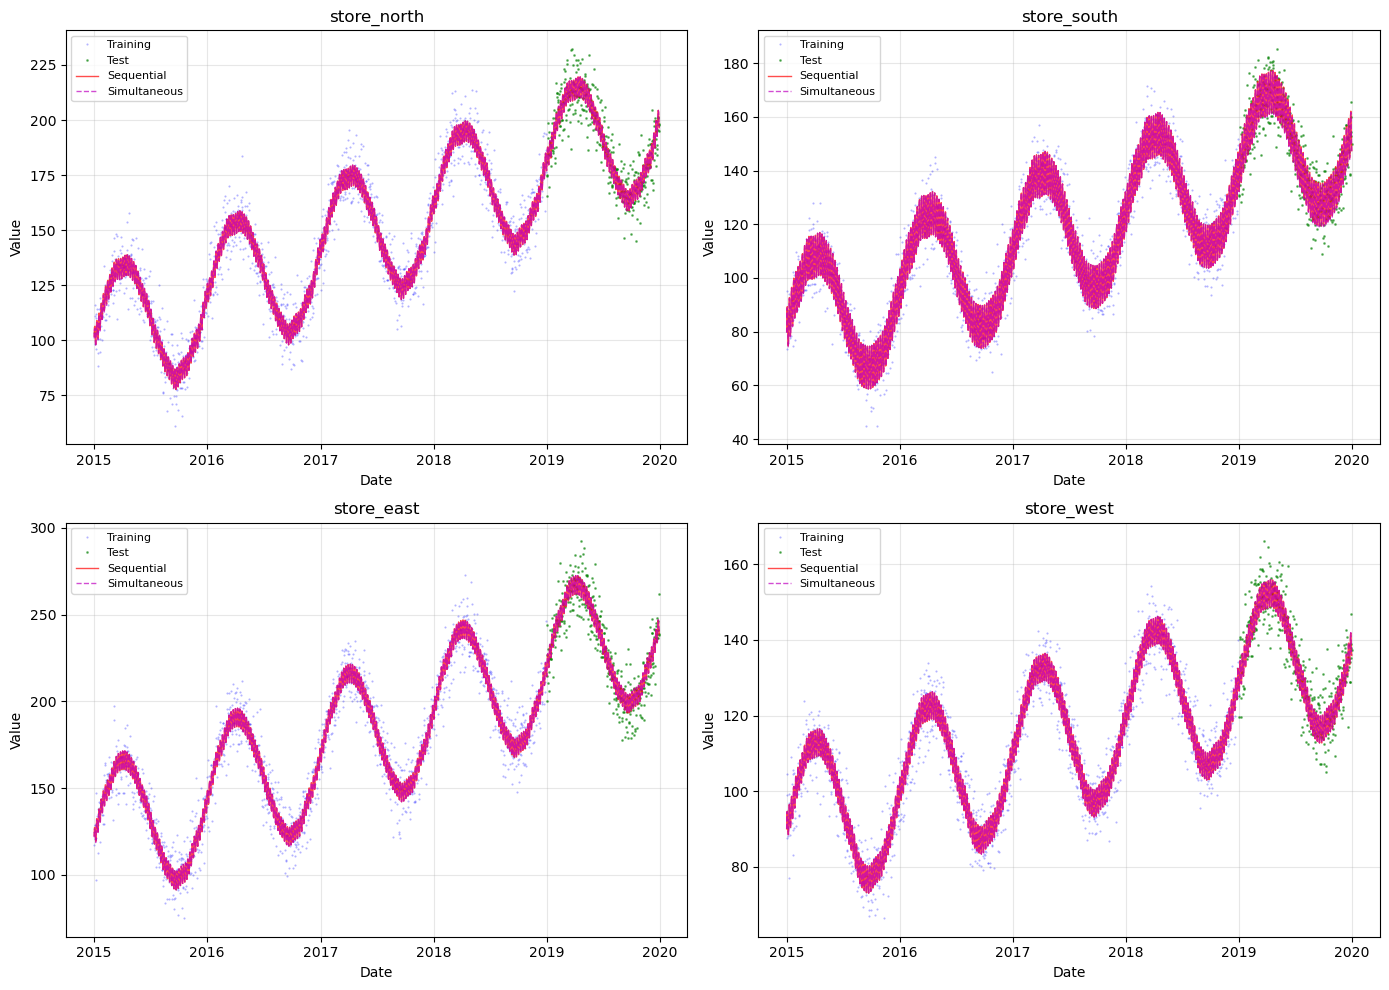

In [17]:
# Visual comparison for a few series
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (ax, params) in enumerate(zip(axes, series_params[:4])):
    name = params["name"]
    train_df = train_series[i]
    test_df = test_series[i]

    # Sequential prediction
    future_seq = sequential_futures[i]

    # Simultaneous prediction
    group_code = [k for k, v in model_combined.groups_.items() if v == name][0]

    ax.plot(
        train_df["ds"], train_df["y"], "b.", markersize=1, alpha=0.3, label="Training"
    )
    ax.plot(test_df["ds"], test_df["y"], "g.", markersize=2, alpha=0.5, label="Test")
    ax.plot(
        future_seq["ds"],
        future_seq["yhat_0"],
        "r-",
        linewidth=1,
        alpha=0.7,
        label="Sequential",
    )
    ax.plot(
        future_combined["ds"],
        future_combined[f"yhat_{group_code}"],
        "m--",
        linewidth=1,
        alpha=0.7,
        label="Simultaneous",
    )

    ax.set_title(name)
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary

### Key Findings

1. **Equivalent Results**: When all series share the same time range, sequential and simultaneous fitting produce **nearly identical results**. Small differences are due to optimization randomness.

2. **Significant Speedup**: Simultaneous fitting is substantially faster due to:
   - Single model compilation (vs. N separate compilations)
   - Vectorized JAX computations across all series
   - The speedup increases with more time series

3. **Scalability**: While we demonstrated with 5 series, vangja can handle hundreds of time series simultaneously, making it ideal for:
   - Retail demand forecasting (many SKUs)
   - Energy load forecasting (many meters)
   - Financial time series (many stocks)

### When to Use Simultaneous Fitting

| Scenario | Recommendation |
|----------|----------------|
| Many series, same time range | ✅ Use simultaneous fitting |
| Few series (<3) | Either approach works |
| Different model per series | Use sequential fitting |
| Series with different date ranges | See Chapter 04 for caveats |

### Important Caveats

Simultaneous fitting works best when series share the **same time range**. When fitting series with very different date ranges (e.g., 1949-1960 vs 2007-2016), there are important considerations:

- **Changepoint placement**: The `n_changepoints` are distributed across the entire combined time range, so each individual series may get fewer changepoints than expected
- **Time normalization**: Each series occupies only a portion of `t = [0, 1]`
- **Prediction filtering**: You must filter predictions to each series' relevant date range

**See Chapter 04: Multi-Series Fitting Caveats** for detailed examples and solutions.